# Cooling of coffee
The aim of the simulation is to predict the time it will take for freshly brewed coffee to cool to drinking temperature. 
Furthermore, we will investigate the processes that are involved in the cooling process.

## Imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pyvista as pv
pv.set_jupyter_backend('static')

## Model creation

### Build cup and coffee 
We build a model of the heat exchange between a cup of hot cofee and its surroundings.
The model uses a lumped parameter approach. We start with a description of the cup geometry. This is done using a body assembly of cylindrical bodies and heat exchange surfaces for contact with cofee and for contact with surroundings.

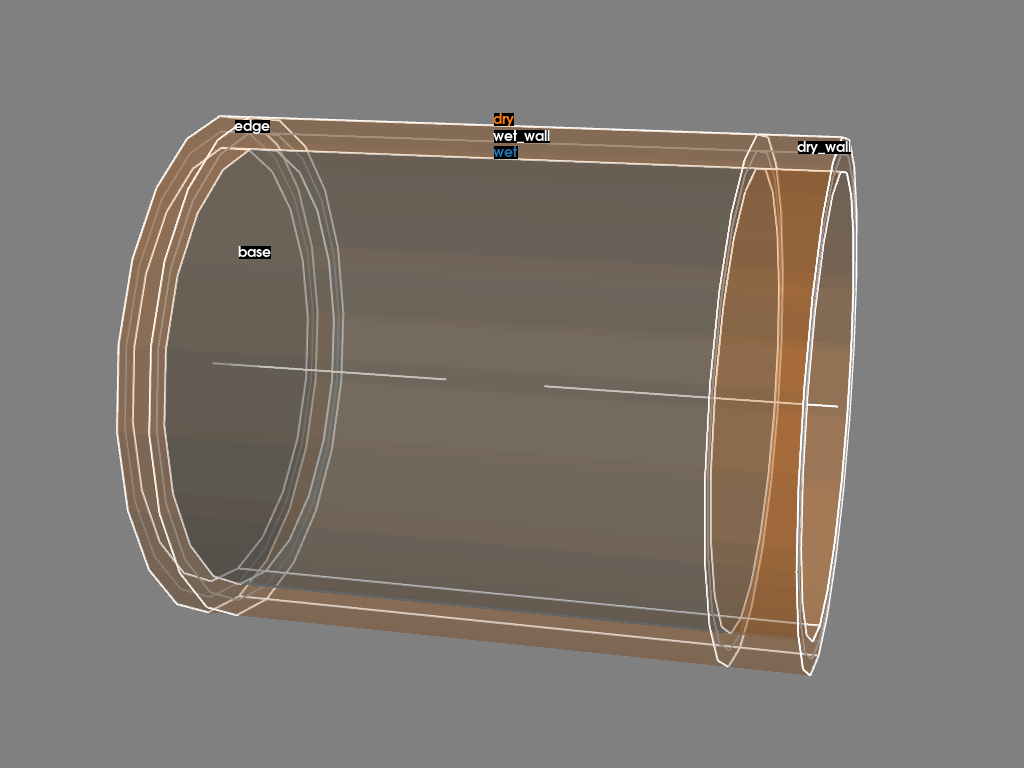

In [2]:
from thermca import *

cup_height = .095
cup_outer_rad = .0395
cup_wall_thkns = 0.0049
cup_inner_rad = cup_outer_rad - cup_wall_thkns 
air_fill_height = .012
coffee_height = cup_height - cup_wall_thkns - air_fill_height

with Asm() as asm:
    base = Cyl(
        outer_rad=cup_inner_rad, 
        lgth=cup_wall_thkns,
        name='base'
    )
    wet_wall = Cyl(
        posn=(cup_wall_thkns, 0., 0.), 
        inner_rad=cup_inner_rad, 
        outer_rad=cup_outer_rad, 
        lgth=coffee_height,
        rad_div=2,
        name='wet_wall',
    )
    dry_wall = Cyl(
        posn=(cup_wall_thkns + coffee_height, 0., 0.), 
        inner_rad=cup_inner_rad, 
        outer_rad=cup_outer_rad, 
        lgth=air_fill_height,                     
        rad_div=2,
        name='dry_wall',
    )
    edge = Cyl(
        inner_rad=cup_inner_rad, 
        outer_rad=cup_outer_rad,
        lgth=cup_wall_thkns,               
        rad_div=2,
        name='edge'
    )
    Surf(
        name='wet',
        faces=[base.face.end, wet_wall.face.inner]
    )
    Surf(
        name='dry',
        faces=[
            base.face.base, 
            edge.face.base, 
            edge.face.outer, 
            wet_wall.face.outer,
            dry_wall.face.outer, 
            dry_wall.face.end, 
            dry_wall.face.inner
        ]
    )

def show_thight(plot):
    plot.camera.zoom(1.3)
    plot.show()
    
show_thight(asm.plot())

The coffee is modelled as a water point node. Coffee can't be modelled as a cylinder because we have to take into account the heat transfer processes of convection, radiation and evaporation. A common way is to model the fluid as a point node holding the bulk temperature. The heat transfer processes are modelled using film coefficients calculated in simplified empirical models.

In [3]:
from math import tau

air_temp = 25.
init_coffee_temp = 100.

with Model() as model:
    cup = LPPart(
        asm=asm,
        matl = solids.porcelain,
        init_temp=air_temp + .1,
        name='cup',
    )
    coffee = MatlNode(
        matl=fluids.water, 
        init_temp=init_coffee_temp,
        vol=tau/2.*cup_inner_rad**2*coffee_height, 
        posn=(coffee_height/2.+cup_wall_thkns, 0., 0.), 
        name='coffee'
    )

### Build surroundings
To evaluate the quantity of each of the heat transfer processes between cup and surroundings separate sinks are used for each of these phenomena. 

In [4]:
with model:
    evap_sink = BoundNode(
        temp=air_temp, 
        posn=(.1, .015, 0.), 
        name='evaporation_sink',
    )
    conv_sink = BoundNode(         
        posn=(.02, .055, 0.), 
        temp=air_temp,
        name='convection_sink',
    )
    radn_sink = BoundNode(
        temp=air_temp, 
        posn=(.07, .055, 0.), 
        name='radiation_sink',
    )

### Modeling of heat tansfer processes
The heat transfer processes between coffe, cup and surroundings are free and forced convection, heat radiation as well as evaporation. They are modeled by empirical approachs. The approachs are implemented in functions that return film coefficients. The approachs may be dependent on the temperature of the surface of the solid and/or the fluid. Approaches for common heat transfer processes are are already available in a library.

#### Link coffe with cup

In [5]:
free_conv_cup = free_conv.vert_surf(surf_hgt=cup_height)
with model:    
    # Link cup with coffee 
    coffee_conv = FilmLink(
        cup.surf.wet, 
        coffee,          
        free_conv_cup,
        matl=fluids.water,
    )       
    # Link cup with surroundings by concvection
    air_conv = FilmLink(         
        cup.surf.dry,
        conv_sink,
        free_conv_cup,
        matl=fluids.air,
    )
    # Link cup with surroundings by radiation
    emis_room = .8  # Emission coefficient room surfaces
    radn = FilmLink(         
        cup.surf.dry,
        radn_sink,
        radiation.therm_radn(res_emis=.8*emis_room)
    )

#### Link coffe surface with surroundings
Coffee as point node has no geometry.
Therefore film coefficients to the surroundings
don't work. It must be linked as conductance.
Conductance = area*film_coefficient

In [6]:
area = tau/2.*cup_inner_rad**2.
with model:
    # Link coffee surface with surroundings by convection and radiation
    coffee_surf_conv = CondLink(
        coffee, 
        conv_sink,
        free_conv.horiz_top_surf(surf_width=2*cup_inner_rad, factor=area),
        matl=fluids.air,
    )
    coffee_surf_radn = CondLink(
        coffee, 
        radn_sink,
        radiation.therm_radn(res_emis=.8*emis_room, factor=area)
    )
    # Link coffee surface with surroundings by evaporation
    evap = CondLink(
        coffee, 
        evap_sink, 
        evaporation.free_forc_water_to_air(
            vel=0., 
            rel_hum=.6,
            factor=area
        )
    )

### Plot the model

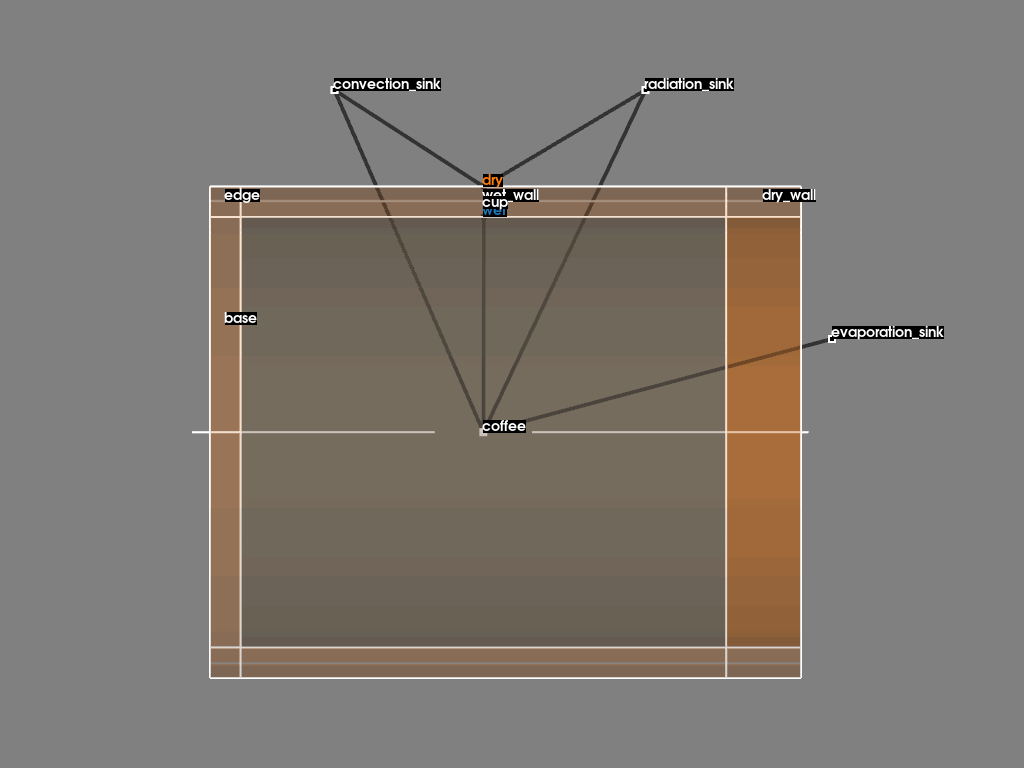

In [7]:
show_thight(model.plot(draw_2d=True))

## Create a runnable network
Plot network with initial temperatures.
The plot shows the capacities of the network nodes as 
spheres and the conductances between the nodes as cylinders. 
The volume of these symbols is scaled by the magnitude of their values.
The bound (constant) temperature of the environment nodes is drawn as six cones touching at their tips.

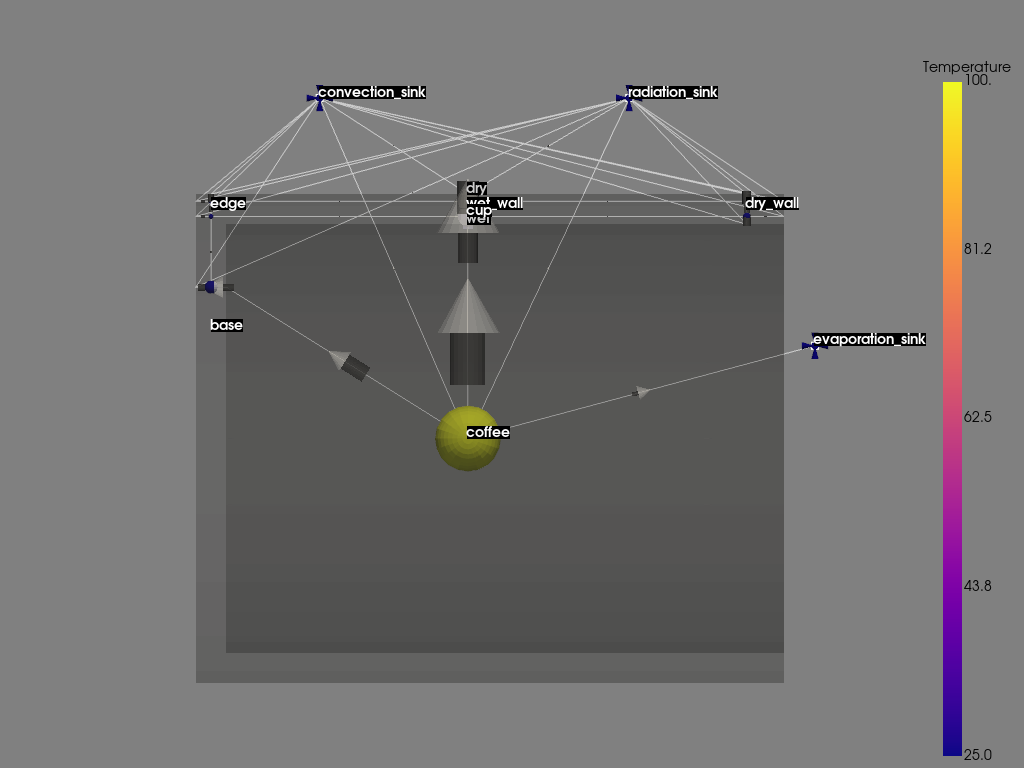

In [8]:
net = Network(model)
show_thight(net.plot(draw_2d=True))

## Run the network
The transient thermal behaviour is simulated.

In [9]:
net = Network(model)
sim_period = 20*60
# increase accuracy because of nonlinear links
result = net.sim([0., sim_period], rel_tol=1e-5)

Simulation run progress, speed as sim. time vs. real time:
 0% 100% done.


Plot the result on the end of the simulation period.

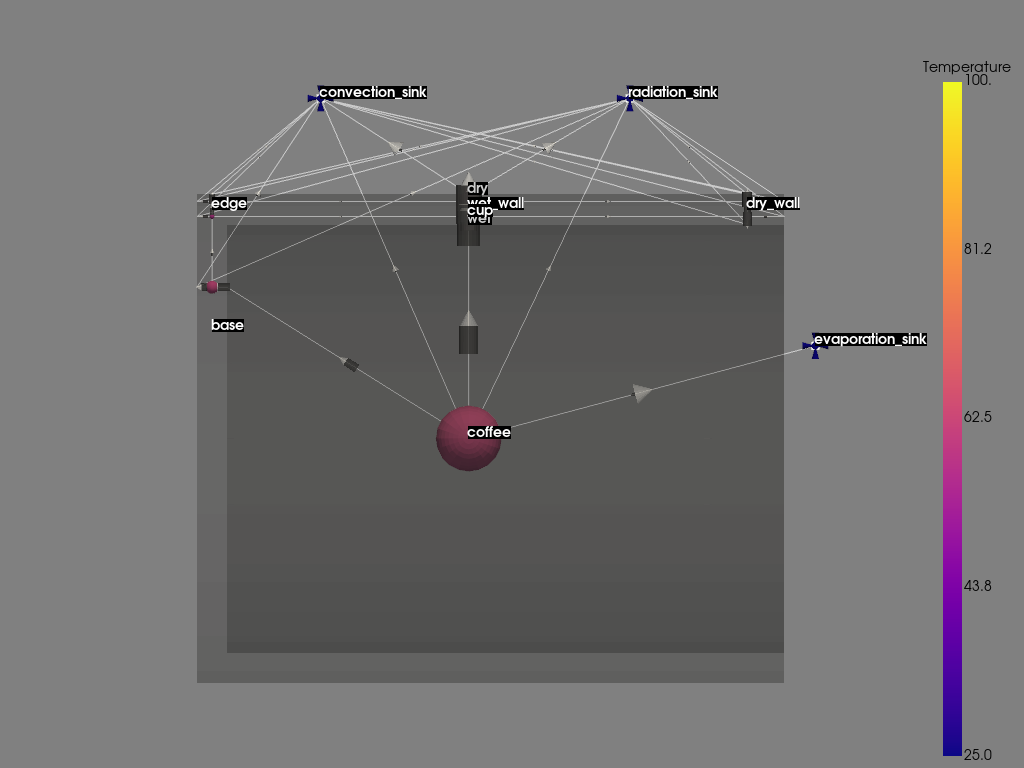

In [10]:
show_thight(result.plot(sim_period, draw_2d=True))

## Print and plot temperature curves with pandas data frames
Using pandas data frames as container for results makes printing and plotting easier. Additionally the output is much clearer. Besides a nice formatting the labels given in the model elements are used to label the data.

In [11]:
from numpy import linspace
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
times = linspace(0., sim_period, 10)  # get results at 10 points over time
temp_df = result[coffee].temp_frame(times)
temp_df = temp_df.join(result[cup.surf.wet].temp_frame(times))
temp_df.index /= 60.
temp_df.index.name = 'Time in min'
temp_df

Temperature,coffee,cup.wet
Time in min,,
0.00,100.00,25.10
2.22,82.03,80.04
4.44,78.43,77.13
6.67,75.43,74.14
8.89,72.76,71.50
11.11,70.32,69.12
13.33,68.10,66.94
15.56,66.06,64.93
17.78,64.17,63.08


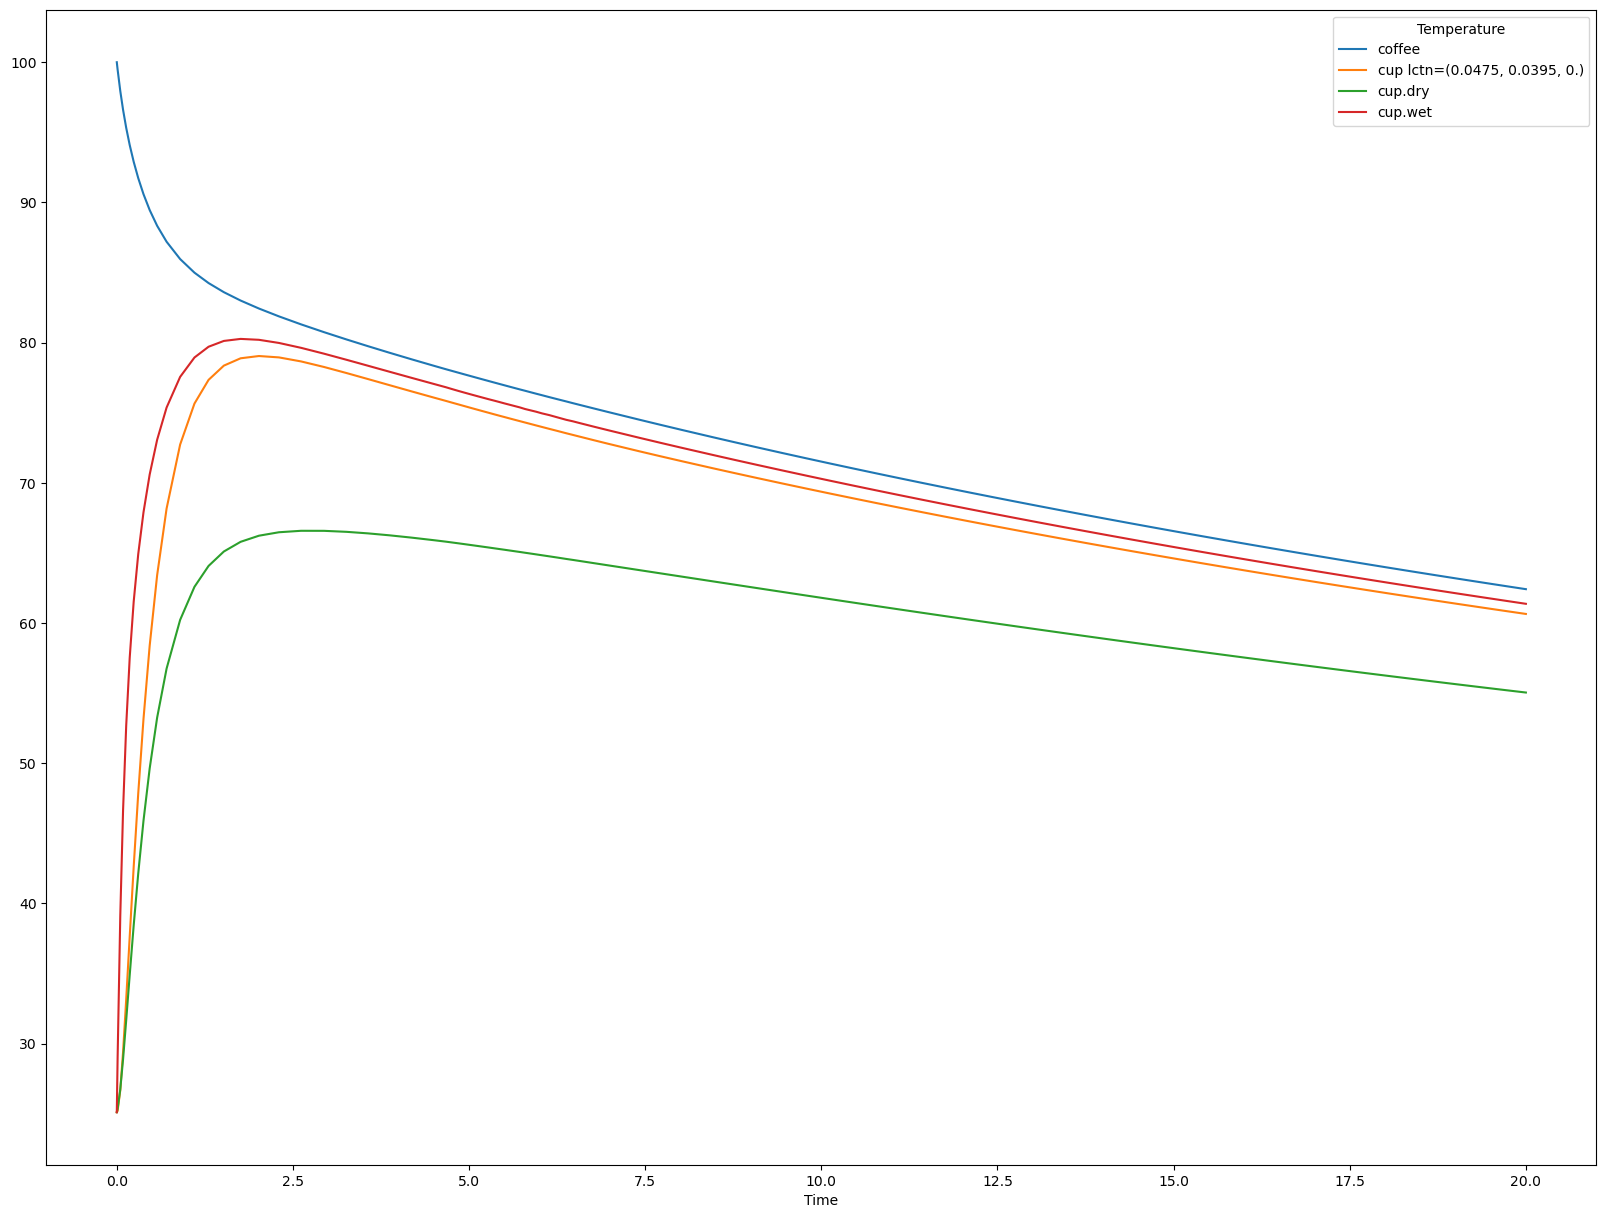

In [12]:
temp_df = pd.concat([
    result[coffee].temp_frame(),
    result[cup].temp_frame(lctn=[(cup_height/2, cup_outer_rad, 0.)]),
    result[cup.surf.dry].temp_frame(),
    result[cup.surf.wet].temp_frame(),
], axis=1)
figsize=(20, 15)  # Adjust desired figure size here
temp_df.index /= 60.
temp_df.plot(figsize=figsize);

## Plot film coefficients with pandas data frames

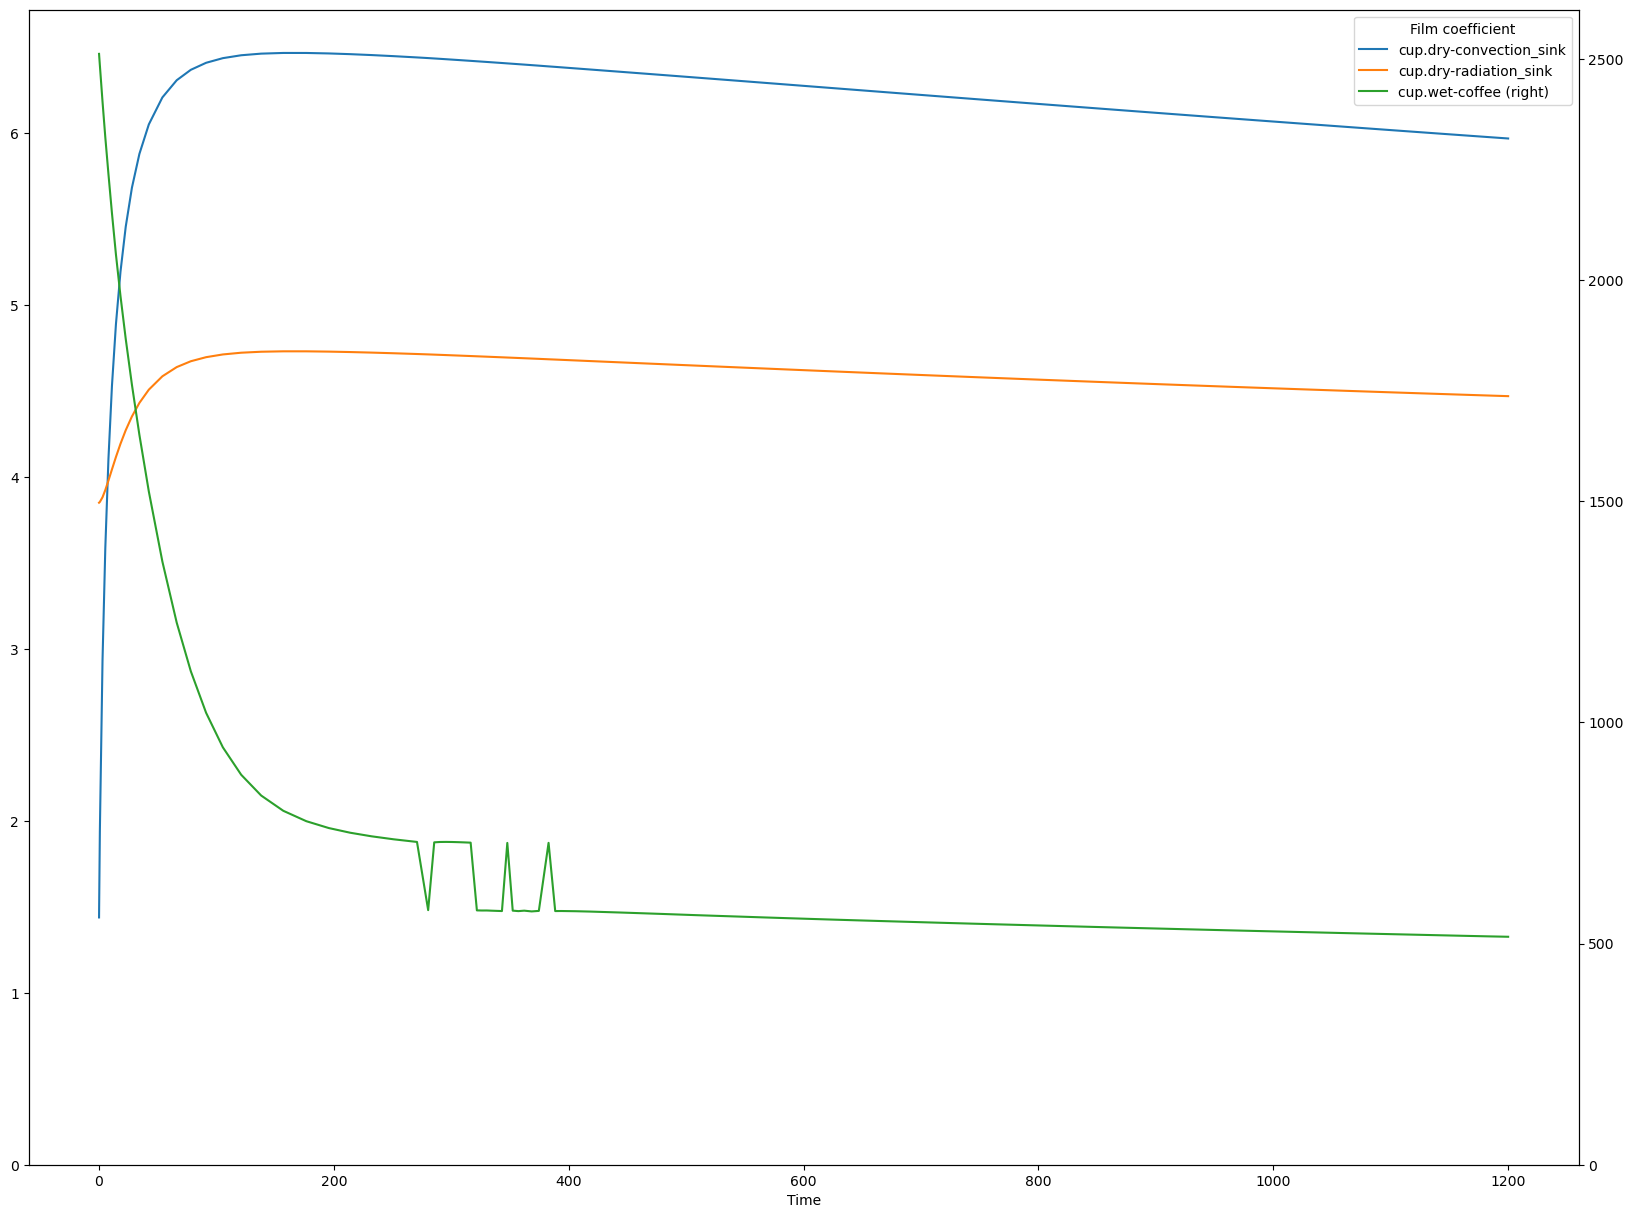

In [13]:
conv_film_df = pd.concat([
    result[air_conv].film_frame(),
    result[radn].film_frame(),
    result[coffee_conv].film_frame(),
], axis=1)
ax = conv_film_df.plot(
    secondary_y=conv_film_df.columns[2], 
    figsize=figsize
)
ax.set_ylim(bottom=0)
ax.right_ax.set_ylim(bottom=0);

## Energy emission sum over time

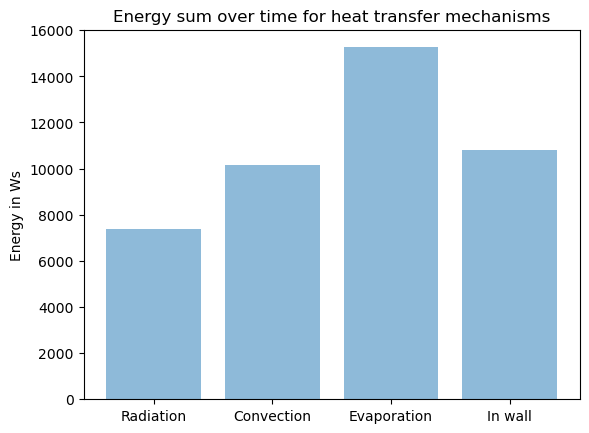

In [14]:
radn_heat = pd.concat([
    result[radn].heat_frame(),
    result[coffee_surf_radn].heat_frame(),
], axis=1)
sample_times = radn_heat.index.to_series()
time_deltas = sample_times - sample_times.shift()
radn_energy = radn_heat.mul(time_deltas, axis=0)

conv_heat = pd.concat([
    result[air_conv].heat_frame(),
    result[coffee_surf_conv].heat_frame(),
], axis=1)    
conv_energy = conv_heat.mul(time_deltas, axis=0)

evap_heat = result[evap].heat_frame()
evap_energy = evap_heat.mul(time_deltas, axis=0)

capy = result[cup].capy(0.)
temp_diff = result[cup].temp(sim_period) - result[cup].temp(0.)
wall_energy = temp_diff*capy

labels = ['Radiation', 'Convection', 'Evaporation', 'In wall']
energy =[radn_energy.sum().sum(), conv_energy.sum().sum(), evap_energy.sum().sum(), wall_energy]
y_pos = np.arange(len(energy))
plt.bar(y_pos, energy, align='center', alpha=0.5) 
plt.xticks(y_pos, labels)
plt.ylabel('Energy in Ws')
plt.title('Energy sum over time for heat transfer mechanisms');

## Comparison with reality
The the simulation with this relative simple model shows a quite similar qualitative behaviour as the real world. This can be seen by a comparison with infrared measurements on a real coffee cup. Some deviations can be seen on the beginning course of the plots that show the rising temperature of the outer cup wall. The reason could be the forced convection between the coffee and the inner cup wall caused by pouring in the cooking coffee. This is currently not taken into account by the model. Further the measured coffee temperature is the temperature of the cooled surface. Therefore the measured temperature is lower than the simulated mean temperature. This can be concluded by comparison of the measured temperatures. In reality the mean water temperature must always be higher than the outer wall temperature. The measured values do not show this behaviour.

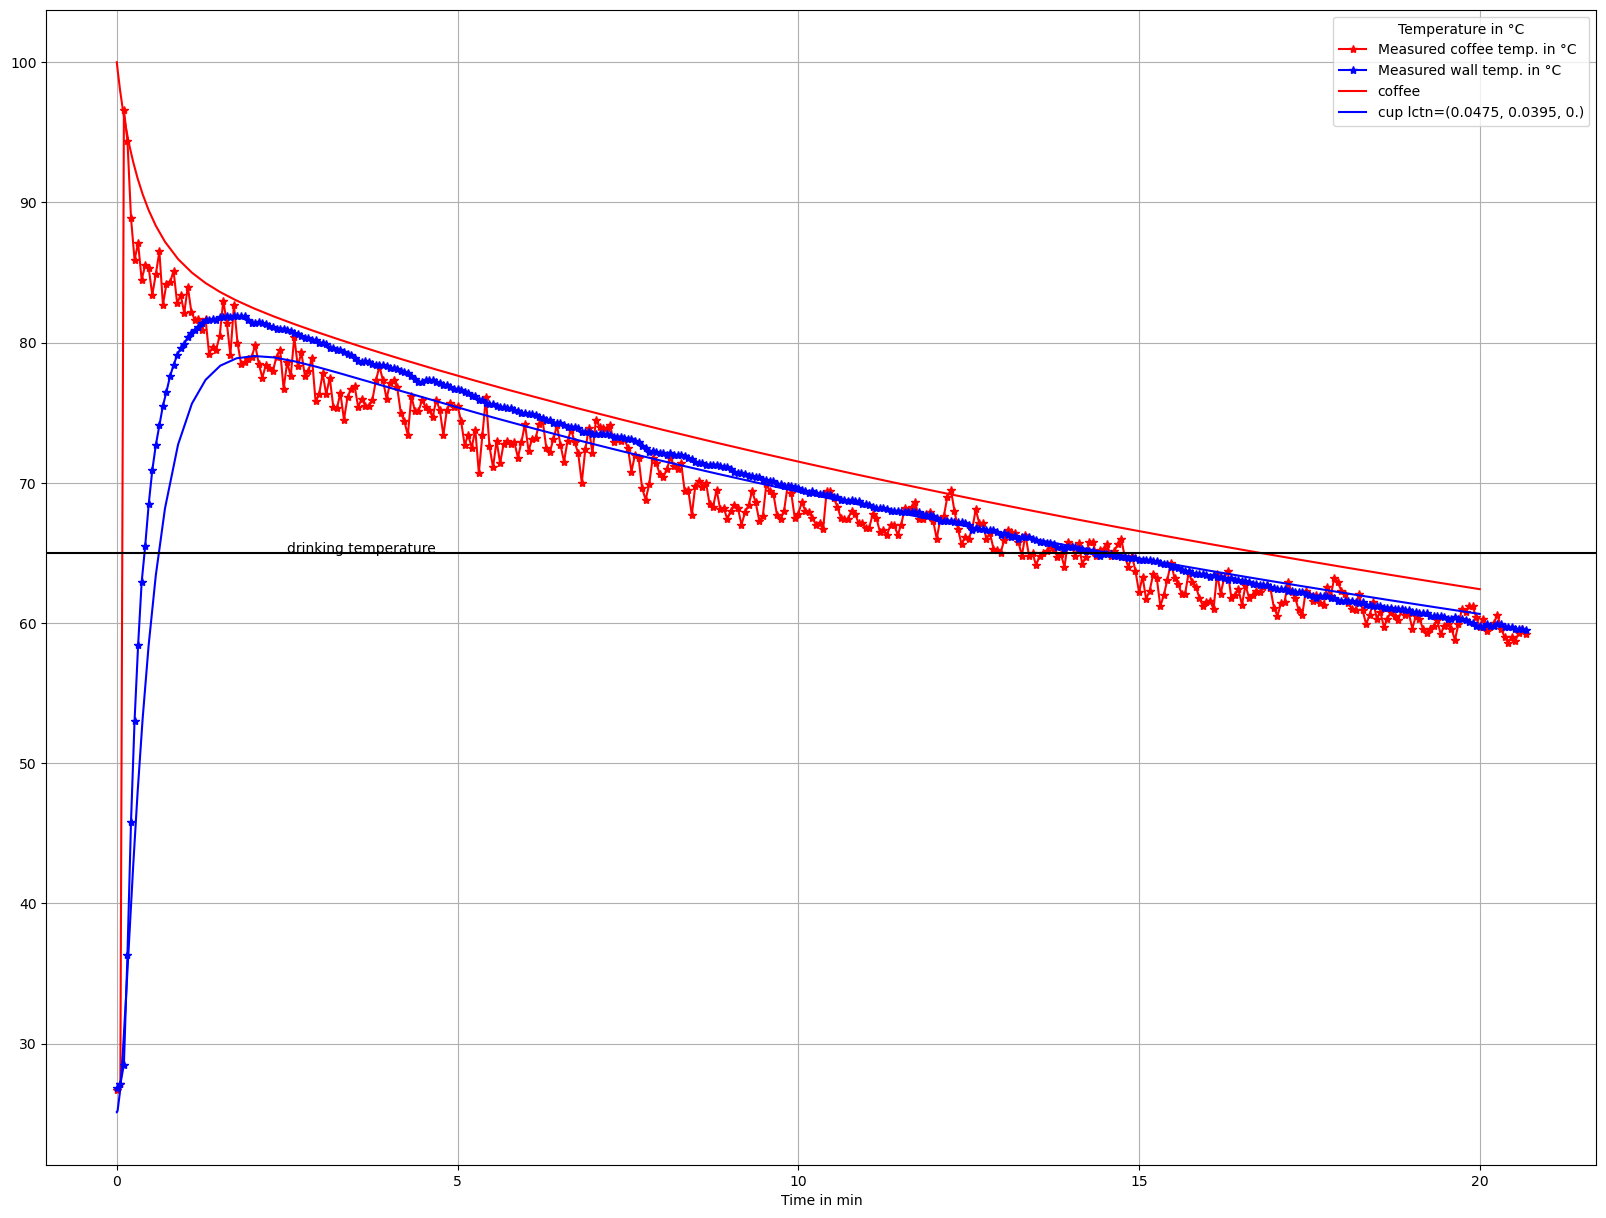

In [15]:
meas_result = pd.read_csv(
    'Cooling coffee infrared temperature measurement.csv',
    delimiter=';',
    encoding ='utf-8').set_index('Time in s')
sim_lctns = [None, (.04, cup_outer_rad)]
sim_result = pd.concat([
    result[coffee].temp_frame(),
    result[cup].temp_frame(lctn=[(cup_height/2, cup_outer_rad, 0.)]),
], axis=1)     
sim_and_meas_result = pd.concat([sim_result, meas_result], sort=True)
sim_and_meas_result.index /= 60.
sim_and_meas_result.index.name = 'Time in min'
sim_and_meas_result.columns.name = 'Temperature in °C'
sim_and_meas_result.plot(
    figsize=figsize, 
    style=['r*-', 'b*-', 'r-', 'b-'],
    grid=True,
);
plt.axhline(y=65, color='k');  # 
plt.text(2.5,65,'drinking temperature');